In [46]:
# 挂载 google 云盘
from google.colab import drive
drive.mount('/content/gdrive')

# 将文件路径指定为数据路径
import os
os.chdir('/content/gdrive/My Drive/comment')

# 第一次使用该语句可下载词向量数据集压缩包，其后可忽略，
# !wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
# 解压缩
# !unzip 'wiki-news-300d-1M.vec.zip'

# 导入必要的库

# 计算库
import numpy as np
import pandas as pd

from tqdm import tqdm #显示运行进度条
import io

# 画图库
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt

# 文字处理库
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
nltk.download('stopwords') #下载停止词
import string
from keras.preprocessing import sequence

# 深度学习库
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, Dense, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D
from keras import optimizers, metrics
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# 随机种子
import random
random.seed(0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
print('正在加载数据文件......')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print('训练集中一共有 {} 条评论'.format(train_data.shape[0]))
print('测试集中一共有 {} 条评论'.format(test_data.shape[0]))
print('训练集中前5个样本为：')
display(train_data.head())
print('训练集是否有数值缺失？{}'.format(train_data.isnull().values.any()))
print('测试集是否有数值缺失？{}'.format(test_data.isnull().values.any()))

print('正在加载词向量......')
fin = io.open('wiki-news-300d-1M.vec', 'r', encoding='utf-8')
embeddings = {} #词向量字典
word_features = 0 #词向量维度
for line in tqdm(fin):
    tokens =  line.split()
    embeddings[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
    word_features = max(word_features, len(tokens[1:]))
fin.close()
print('找到 {} 个词向量'.format(len(embeddings)))
print('每个词向量的维度为 {}'.format(word_features))

正在加载数据文件......
训练集中一共有 159571 条评论
测试集中一共有 153164 条评论
训练集中前5个样本为：


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


训练集是否有数值缺失？False
测试集是否有数值缺失？False


训练集样本可视化


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


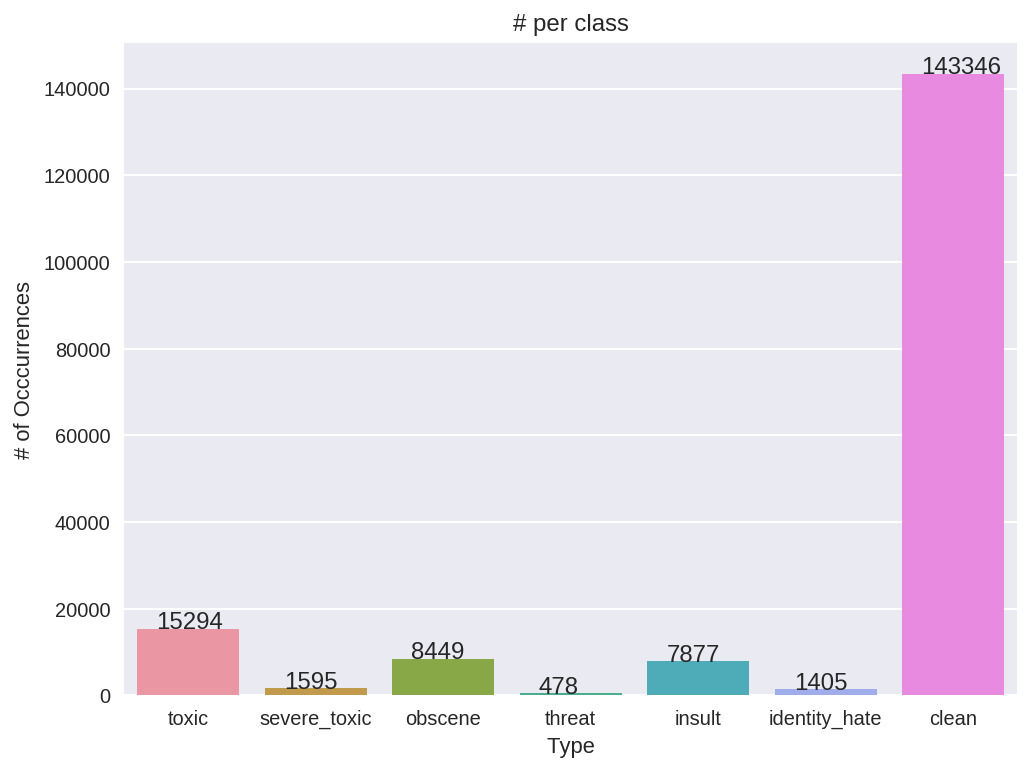

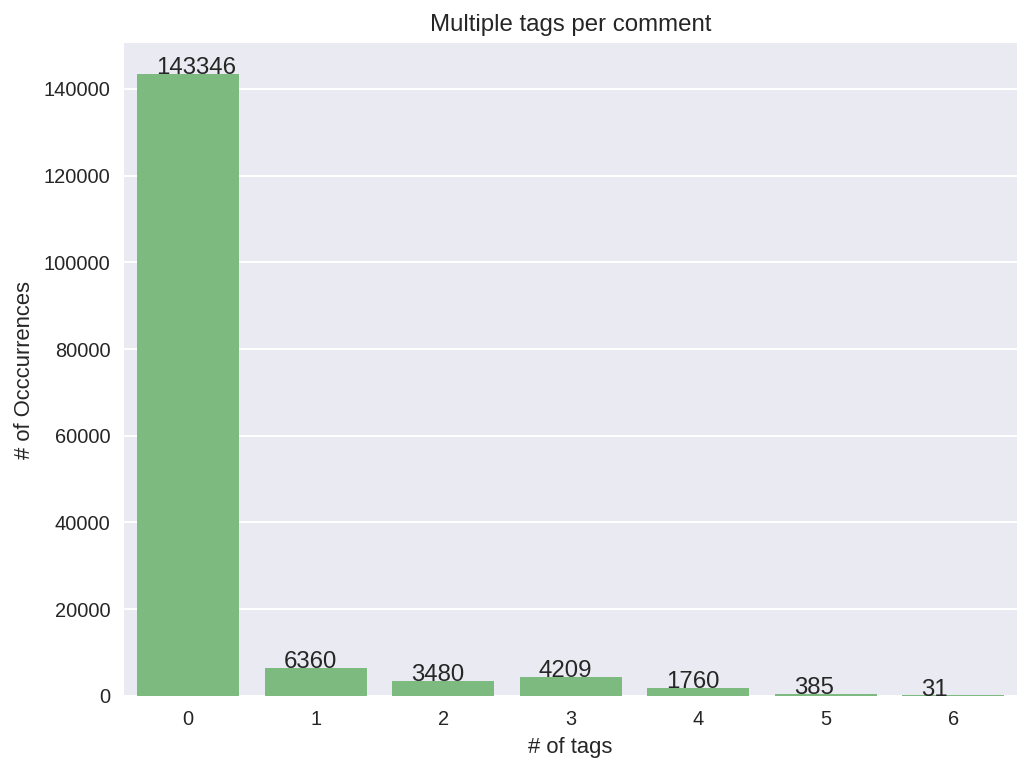

评论长度分布可视化


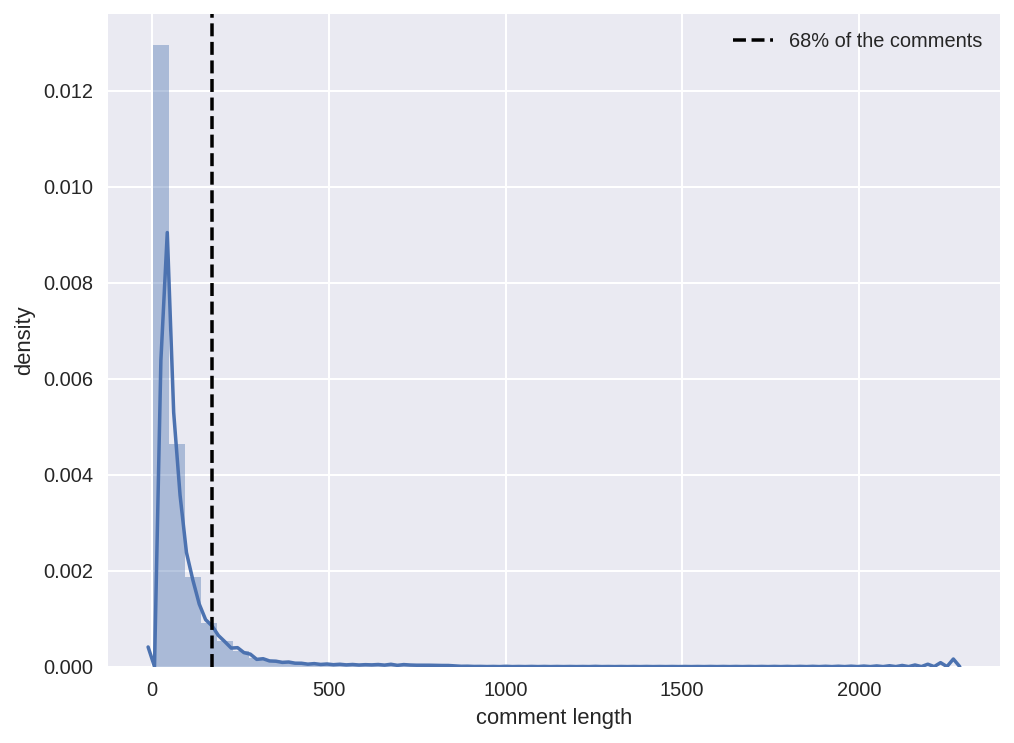

最长的评论字数为：2273
68% 的评论少于 169 字


In [40]:
print('训练集样本可视化')
sb.set(rc={"figure.figsize": (8, 6)})
stats = {}
labels = train_data.columns[2:].tolist()
for label in labels:
    stats[label] = train_data[train_data[label] == 1][label].count()
    
col_sum = train_data[labels].apply(lambda x: x.sum(), axis=1)
stats['clean'] = (col_sum == 0).sum()
x = list(stats.keys())
y = list(stats.values())
sb.barplot(x, y)
plt.title('# per class')
plt.xlabel('Type')
plt.ylabel('# of Occcurrences')
for a,b in enumerate(y):
    plt.text(a-0.25, b+0.05, s=b)
plt.show()

tag_num = {}
for count in range(len(labels)+1):
    tag_num[count] = (col_sum == count).sum()
x = list(tag_num.keys())
y = list(tag_num.values())
sb.barplot(x, y, palette=sb.color_palette("Greens", 1))
plt.title('Multiple tags per comment')
plt.xlabel('# of tags')
plt.ylabel('# of Occcurrences')
for a,b in enumerate(y):
    plt.text(a-0.25, b+0.05, s=b)
plt.show()


print('评论长度分布可视化')
comment_len = train_data['comment_text'].apply(lambda x: len(x.split(' ')))
# 位于长度一个标准偏差的位置的评论长度
maxlen = np.ceil(np.mean(comment_len) + 1*np.std(comment_len)).astype('int')
sb.distplot(comment_len)
plt.axvline(x=maxlen, color='k', linestyle='--', label='68% of the comments')
plt.xlabel('comment length'); 
plt.ylabel('density');
plt.legend()
plt.show()
print('最长的评论字数为：{}'.format(np.max(comment_len)))
print('68% 的评论少于 {} 字'.format(maxlen))

In [44]:

# 过滤掉停止词及标点
stop_words = set(stopwords.words('english'))
stop_words.update(string.punctuation)
train_refined, test_refined = [], []
# 元素化评论,过滤评论中停止词及标点
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
print('训练集文本处理中......')
for line in tqdm(train_data['comment_text']):
    train_refined.append(' '.join([word for word in tokenizer.tokenize(line) if word not in stop_words]))
print('测试集文本处理中......')
for line in tqdm(test_data['comment_text']):
    test_refined.append(' '.join([word for word in tokenizer.tokenize(line) if word not in stop_words]))

word_upper = 100000 # 词量上限
# 基于词频，保留前 100000 个词
tokenizer = Tokenizer(num_words=word_upper)
# 创建评论词典，一个单词对应一个索引
tokenizer.fit_on_texts(train_refined + test_refined)
token_train, token_test = map(lambda x: tokenizer.texts_to_sequences(x), [train_refined, test_refined])
word_index = tokenizer.word_index
print('评论中的词汇量为 {}'.format(len(word_index)))

seq_train, seq_test = map(lambda x: sequence.pad_sequences(x, maxlen=maxlen), [token_train, token_test])
feature_matrix = np.zeros((min(word_upper, len(word_index)), word_features))
for word, index in tqdm(word_index.items()):
    if index >= min(word_upper, len(word_index)):
      continue
    word_vec = embeddings.get(word)
    if word_vec is not None:
        feature_matrix[index] = word_vec


  2%|▏         | 2800/159571 [00:00<00:05, 27985.21it/s]

训练集文本处理中......


  2%|▏         | 2786/153164 [00:00<00:05, 27779.16it/s]

测试集文本处理中......


100%|██████████| 153164/153164 [00:04<00:00, 31637.79it/s]


评论中的词汇量为 372313


100%|██████████| 372313/372313 [00:00<00:00, 634012.32it/s]


In [54]:

filters = 64
model = Sequential()
model.add(Embedding(word_upper, 
                    word_features,
                    input_length = maxlen,
                    weights=[feature_matrix],
                    trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(filters, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters, 5, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(len(labels), activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
callbacks = [EarlyStopping(monitor='val_loss', 
                          min_delta=0.001, 
                          patience=3, 
                          verbose=1)]

batch_size = 256
epochs = 10
X_train, X_val, y_train, y_val = train_test_split(seq_train, 
                                                  train_data[labels].values, 
                                                  train_size=0.9, 
                                                  random_state=0)
hist = model.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                validation_data=(X_val, y_val),
                verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 169, 300)          30000000  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 169, 300)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 165, 64)           96064     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 82, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 78, 64)            20544     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
__________

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 15s 108us/step - loss: 0.3046 - acc: 0.9716 - val_loss: 0.2988 - val_acc: 0.9927
Epoch 2/10
143613/143613 [==============================] - 14s 98us/step - loss: 0.2909 - acc: 0.9870 - val_loss: 0.2935 - val_acc: 0.9763
Epoch 3/10
143613/143613 [==============================] - 14s 98us/step - loss: 0.2857 - acc: 0.9823 - val_loss: 0.2876 - val_acc: 0.9805
Epoch 4/10
143613/143613 [==============================] - 14s 98us/step - loss: 0.2828 - acc: 0.9824 - val_loss: 0.2869 - val_acc: 0.9846
Epoch 5/10
143613/143613 [==============================] - 14s 98us/step - loss: 0.2804 - acc: 0.9835 - val_loss: 0.2866 - val_acc: 0.9823
Epoch 6/10
143613/143613 [==============================] - 14s 98us/step - loss: 0.2786 - acc: 0.9835 - val_loss: 0.2846 - val_acc: 0.9811
Epoch 7/10
143613/143613 [==============================] - 14s 98us/step - loss: 0.2767 - acc: 0.9837 - val

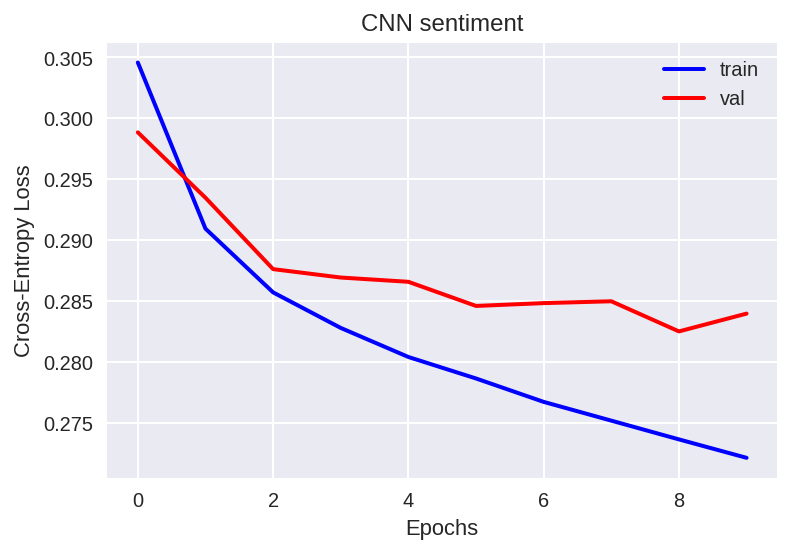

In [55]:
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

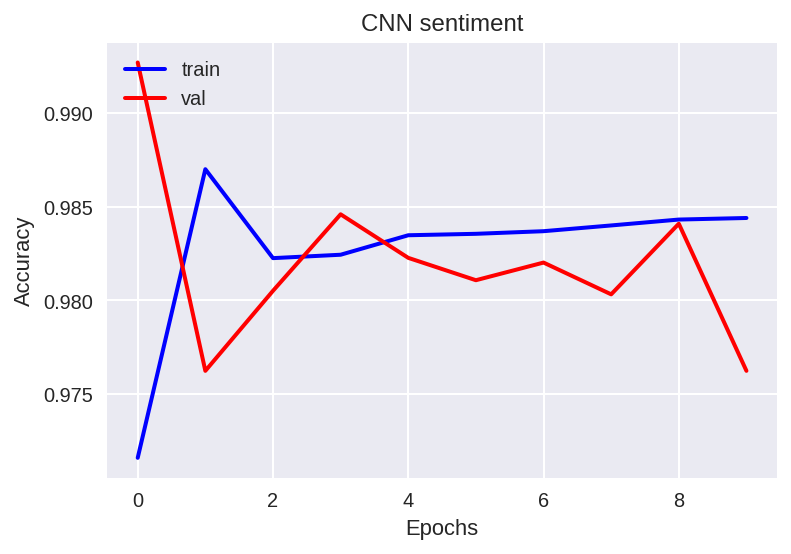

In [56]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
# plt.ylim((0.99408,0.99420))
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [0]:
y_test = model.predict(seq_test)

In [0]:
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_data['id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("./cnn_fasttext_submission.csv", index=False)

In [53]:
submission_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.232221,0.145807,0.21451,0.0560979,0.21125,0.140114
1,0000247867823ef7,0.574715,0.0134813,0.187153,0.00951502,0.194319,0.0208171
2,00013b17ad220c46,0.499959,0.0214521,0.234965,0.00948058,0.209485,0.0246581
3,00017563c3f7919a,0.673746,0.00349265,0.169252,0.00237388,0.146216,0.00492013
4,00017695ad8997eb,0.568681,0.0144005,0.198131,0.00967796,0.191107,0.0180024


In [0]:
sample = pd.read_csv('sample_submission.csv')

In [82]:
sample.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [83]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
